In [1]:
import pandas as pd
from datasets import load_dataset
from matplotlib import pyplot as plt
from Huggingface.noteboooks.util import FakeNewsExplainer
%matplotlib inline

2022-08-28 15:29:53.202950: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
model = {
        'NAME': 'GonzaloA/distilroberta-base-finetuned-fakeNews',
        'LABEL_MAPPINGS': {'LABEL_0': 'Fake', 'LABEL_1': 'Real', 0: 'Fake', 1:  'Real'},
        'DATASET': 'GonzaloA/fake_news',
        'EXTERNAL_LINKS': [],
    }
fake_news_explainer = FakeNewsExplainer(model)

Using custom data configuration GonzaloA--fake_news-2fa3f217e39cb456
Reusing dataset parquet (/home/sersery/.cache/huggingface/datasets/GonzaloA___parquet/GonzaloA--fake_news-2fa3f217e39cb456/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

Using device: cuda


2022-08-28 15:30:10.975031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 15:30:10.975430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-08-28 15:30:10.975443: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-28 15:30:10.976138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [16]:
train_dataset = fake_news_explainer.dataset.get('train').to_pandas()
val_dataset = fake_news_explainer.dataset.get('validation').to_pandas()
test_dataset = fake_news_explainer.dataset.get('test').to_pandas()

In [94]:
def plot_label_distribution(ax, ds, fake_color, real_color, label):
    fake_news = ds[ds.label == 0]['label'].apply(lambda x: 'Fake')
    print(f'len fake news {len(fake_news)}')
    real_news = ds[ds.label == 1]['label'].apply(lambda x: 'Real')
    print(f'len real news {len(real_news)}')
    height_offsets = {'fake': 0, 'real': 0}
    for i, rect in enumerate(ax.patches):
        if i%2 == 0:
            height_offsets['fake'] += rect.get_height()
        else:
            height_offsets['real'] += rect.get_height()
    bar = ax.bar(x=['Fake', 'Real'], height=[len(fake_news), len(real_news)], bottom=[height_offsets['fake'], height_offsets['real']], color=[fake_color, real_color], label=label)
    return bar

    # offset = (len(fake_news) + len(real_news)) * 0.25
    # for rect in ax.patches:
    #     print(rect)
    #     plt.text(rect.get_x() + 0.3, rect.get_height() - offset, str(round((rect.get_height()), 5)), fontsize=16,
    #              fontweight='bold', color='black')
    # ax.set_xlabel('News Type')
    # ax.set_ylabel('Count')
    # ax.set_title(title)


def plot_dataset_label_distribution_by_split(train_ds, val_ds, test_ds):
    # fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    # plot_label_distribution(ax0, pd.concat([train_ds, val_ds, test_ds]), 'Dataset Label Distribution')
    # plot_label_distribution(ax1, train_ds, 'Train Split Label Distribution')
    # plot_label_distribution(ax2, val_ds, 'Validation Split Label Distribution')
    # plot_label_distribution(ax3, test_ds, 'Test Split Label Distribution')
    fig, ax = plt.subplots(figsize=(12, 8))
    btrain = plot_label_distribution(ax, train_ds, fake_color='limegreen', real_color='limegreen', label='train')
    bval = plot_label_distribution(ax, val_ds, fake_color='lime', real_color='lime', label='validation')
    btest = plot_label_distribution(ax, test_ds, fake_color='palegreen', real_color='palegreen', label='test')

    ax.set_xlabel('News Type')
    ax.set_ylabel('Count')
    ax.legend()
    # ax.legend(handles=[btrain, bval, btest])
    plt.show()

len fake news 11158
len real news 13195
len fake news 3723
len real news 4394
len fake news 3782
len real news 4335


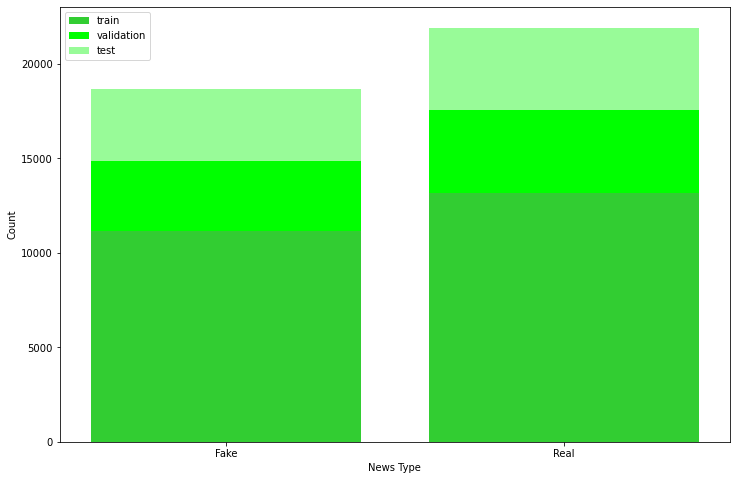

In [95]:
plot_dataset_label_distribution_by_split(train_dataset, val_dataset, test_dataset)

## Now we visualize the most commonly used words as a WordCloud

In [96]:
from wordcloud import WordCloud

In [97]:
# we need to get the most frequent 500 tokens in the train dataset
def get_most_frequent_n_tokens(df: pd.DataFrame, tokenizer, n=500):
    freq_map = {}
    special_tokens = list(tokenizer.special_tokens_map.values())
    for r in df['text']:
        tokenized = tokenizer(r)['input_ids']
        for token in tokenized:
            if token not in special_tokens:
                if token in freq_map.keys():
                    freq_map[token] += 1
                else:
                    freq_map[token] = 1
    freq_df = pd.DataFrame({'tokens': freq_map.keys(), 'frequency': freq_map.values()})
    freq_df = freq_df.sort_values(by='frequency', ascending=False)
    freq_df['tokens'] = freq_df['tokens'].apply(lambda x: tokenizer.decode(x))

    return freq_df[:n]

### Real News WordCloud

In [98]:
real_news_word_frequency_df = get_most_frequent_n_tokens(train_dataset[train_dataset.label == 1], fake_news_explainer.tokenizer)
real_news_word_frequency_df

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


,tokens,frequency
15,the,264867
47,.,257120
32,",",245086
36,to,151567
43,of,128187
...,...,...
576,denied,1402
1097,Tillerson,1399
1628,General,1399
318,become,1398


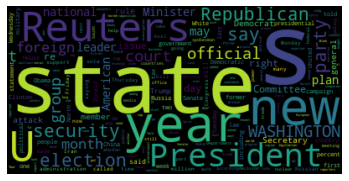

In [99]:
wordcloud = WordCloud().generate('\n'.join(real_news_word_frequency_df['tokens'].values.tolist()))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')

### Fake News WordCloud

In [100]:
fake_news_word_frequency_df = get_most_frequent_n_tokens(train_dataset[train_dataset.label == 0], fake_news_explainer.tokenizer)

### Visualization of most frequent 500 words

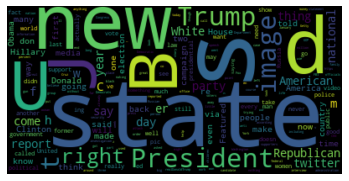

In [101]:
wordcloud = WordCloud().generate('\n'.join(fake_news_word_frequency_df['tokens'].values.tolist()))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')

## Now investigate some words in the datasets

### We first start with "(Reuters)" in train_dataset with true labels

In [102]:
train_dataset_real_news = train_dataset[train_dataset.label == 1]
keyword = '(Reuters)'
rows_with_keyword = []
indexes = []
for row , idx in zip(train_dataset_real_news['text'], train_dataset_real_news.index):
    if keyword in row:
        rows_with_keyword.append(row)
        indexes.append(idx)
print(f'Out of {len(train_dataset_real_news)} samples in train dataset, {len(rows_with_keyword)} ({100 * len(rows_with_keyword) / len(train_dataset_real_news)}%) samples contain {keyword}')


Out of 13195 samples in train dataset, 12658 (95.93027661993179%) samples contain (Reuters)


2
